# Laboratorio #5

**Esteban Zambrano - 22119**<br>
**Edwin Ortega - 22305**<br>
**Diego García - 22404**

### Carga de datos

In [1]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "train.csv", encoding="utf-8", low_memory=False)

print(df.shape)
print(df.columns.tolist())
print(df.isna().mean().round(4))
df.head()

(7613, 5)
['id', 'keyword', 'location', 'text', 'target']
id          0.0000
keyword     0.0080
location    0.3327
text        0.0000
target      0.0000
dtype: float64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
# valida que vengan las columnas esperadas
expected = {"id","keyword","location","text","target"}
missing = expected - set(df.columns)
assert not missing, f"Faltan columnas: {missing}"

### Limpieza y preprocesamiento de datos

In [3]:
import re, string, json
import numpy as np
import pandas as pd
from pathlib import Path
import html, unicodedata

KEEP_911 = True
REMOVE_NUMBERS = True
APPLY_STOPWORDS = True

try:
    from nltk.corpus import stopwords
    STOP = set(stopwords.words("english"))
except Exception:
    try:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
        STOP = set(ENGLISH_STOP_WORDS)
    except Exception:
        STOP = set()

if "df" not in globals():
    df = pd.read_csv("data/train.csv")

In [4]:
SMART_MAP = {
    "’": "'", "‘": "'", "‚": ",", "‛": "'",
    "“": '"', "”": '"', "„": '"', "‟": '"',
    "—": "-", "–": "-", "…": "...",
    "«": '"', "»": '"',
}

def normalize_quotes_dashes(x: str) -> str:
    for a, b in SMART_MAP.items():
        x = x.replace(a, b)
    return x

CTRL_RE = re.compile(r"[\u0000-\u001F\u007F-\u009F]")

def demojibake_once(x: str) -> str:
    """Intenta deshacer una pasada de mojibake (latin-1 / cp1252 -> utf-8)."""
    for enc in ("latin-1", "cp1252"):
        try:
            x = x.encode(enc).decode("utf-8")
        except Exception:
            pass
    return x

def fix_encoding_issues(text: str) -> str:
    if not isinstance(text, str):
        return "" if pd.isna(text) else str(text)

    x = html.unescape(text)
    
    x_prev = None
    for _ in range(2):
        x2 = demojibake_once(x)
        if x2 == x_prev or x2 == x:
            break
        x_prev, x = x, x2

    x = unicodedata.normalize("NFKC", x)
    x = normalize_quotes_dashes(x)
    x = CTRL_RE.sub(" ", x)
    return x

In [5]:
# Patrones regex y funciones de limpieza

URL_PATTERN     = re.compile(r"http[s]?://\S+|www\.\S+")
HTML_PATTERN    = re.compile(r"<.*?>")
HANDLE_PATTERN  = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#(\w+)")
EMOJI_PATTERN   = re.compile("[" # rangos Unicode de emojis
    "\U0001F600-\U0001F64F"  # emoticonos
    "\U0001F300-\U0001F5FF"  # símbolos
    "\U0001F680-\U0001F6FF"  # transporte/mapas
    "\U0001F1E0-\U0001F1FF"  # banderas
    "]+", flags=re.UNICODE)

def _remove_numbers(text: str) -> str:
    if not REMOVE_NUMBERS:
        return text
    if KEEP_911:
        # elimina números aislados, excepto 911
        return re.sub(r"\b(?!911\b)\d+\b", " ", text)
    # elimina todos los números
    return re.sub(r"\d+", " ", text)

def clean_text_basic(s: str) -> str:
    """
    Pasos: 
      1) minúsculas 
      2) quitar URLs y HTML
      3) quitar @handles y '#', conservando la palabra del hashtag
      4) quitar emojis
      5) quitar números (con opción de conservar 911)
      6) quitar puntuación
      7) colapsar espacios
    """
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)

    s = fix_encoding_issues(s)

    x = s.lower()
    x = URL_PATTERN.sub(" ", x)
    x = HTML_PATTERN.sub(" ", x)
    x = HANDLE_PATTERN.sub(" ", x)
    x = HASHTAG_PATTERN.sub(r"\1", x)
    x = EMOJI_PATTERN.sub(" ", x)
    x = _remove_numbers(x)
    x = x.translate(str.maketrans("", "", string.punctuation))
    x = re.sub(r"[^\x00-\x7F]+", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def remove_stopwords(s: str) -> str:
    if not APPLY_STOPWORDS or not STOP:
        return s
    toks = s.split()
    toks = [t for t in toks if t not in STOP]
    return " ".join(toks)

In [6]:
if isinstance(STOP, set):
    STOP.update({"amp", "quot", "lt", "gt"})

In [7]:
# Aplicar la limpieza y crear clean_text
assert {"text","target"}.issubset(df.columns), "Columnas esperadas no encontradas."

df["clean_text"] = df["text"].map(clean_text_basic).map(remove_stopwords)

# Vista rápida de la limpieza
df[["text", "clean_text"]].head(10)


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,forest near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent photo ruby alaska smoke wildfire...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed directi...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...
7,I'm on top of the hill and I can see a fire in...,im hill woods
8,There's an emergency evacuation happening now ...,theres emergency evacuation happening building...
9,I'm afraid that the tornado is coming to our a...,im afraid tornado coming area


In [8]:
# Quitar digitos dentro de tokens, preservando '911' como token completo

def strip_digits_preserve_911(text: str) -> str:
    toks = text.split()
    out = []
    for t in toks:
        if t == "911":
            out.append(t)
        else:
            t2 = re.sub(r"\d+", "", t)  # quita dígitos embebidos
            if t2:  # descarta tokens vacíos
                out.append(t2)
    return " ".join(out)

df["clean_text"] = df["clean_text"].map(strip_digits_preserve_911)

# Verificación rápida
rem = df["clean_text"].str.contains(r"\d").sum()
print(f"Filas con dígitos remanentes: {rem}")

Filas con dígitos remanentes: 4


In [9]:
# Reporta filas con dígitos que NO sean el token 911
def has_non911_digits(s: str) -> bool:
    toks = s.split()
    for t in toks:
        if any(ch.isdigit() for ch in t) and t != "911":
            return True
    return False

mask_bad = df["clean_text"].map(has_non911_digits)
print("Filas con dígitos (excluyendo el token '911'):", int(mask_bad.sum()))

# Ver ejemplos si hubiera alguno:
df.loc[mask_bad, ["text","clean_text"]].head(10)


Filas con dígitos (excluyendo el token '911'): 0


,text,clean_text


In [10]:
# Métricas de impacto de la limpieza
stats = {
    "rows": len(df),
    "nulls_pct": df.isna().mean().round(4).to_dict(),
}
lens_before_chars = df["text"].astype(str).str.len().describe().round(2).to_dict()
lens_after_chars  = df["clean_text"].astype(str).str.len().describe().round(2).to_dict()
lens_before_words = df["text"].astype(str).str.split().map(len).describe().round(2).to_dict()
lens_after_words  = df["clean_text"].astype(str).str.split().map(len).describe().round(2).to_dict()

print("Resumen dataset:\n", json.dumps(stats, indent=2))
print("\nLen (caracteres) - antes:\n", json.dumps(lens_before_chars, indent=2))
print("\nLen (caracteres) - después:\n", json.dumps(lens_after_chars, indent=2))
print("\nLen (palabras) - antes:\n", json.dumps(lens_before_words, indent=2))
print("\nLen (palabras) - después:\n", json.dumps(lens_after_words, indent=2))


Resumen dataset:
 {
  "rows": 7613,
  "nulls_pct": {
    "id": 0.0,
    "keyword": 0.008,
    "location": 0.3327,
    "text": 0.0,
    "target": 0.0,
    "clean_text": 0.0
  }
}

Len (caracteres) - antes:
 {
  "count": 7613.0,
  "mean": 101.16,
  "std": 33.85,
  "min": 7.0,
  "25%": 78.0,
  "50%": 107.0,
  "75%": 133.0,
  "max": 157.0
}

Len (caracteres) - después:
 {
  "count": 7613.0,
  "mean": 56.59,
  "std": 23.67,
  "min": 0.0,
  "25%": 40.0,
  "50%": 57.0,
  "75%": 74.0,
  "max": 138.0
}

Len (palabras) - antes:
 {
  "count": 7613.0,
  "mean": 14.9,
  "std": 5.73,
  "min": 1.0,
  "25%": 11.0,
  "50%": 15.0,
  "75%": 19.0,
  "max": 31.0
}

Len (palabras) - después:
 {
  "count": 7613.0,
  "mean": 8.17,
  "std": 3.33,
  "min": 0.0,
  "25%": 6.0,
  "50%": 8.0,
  "75%": 11.0,
  "max": 21.0
}


In [11]:
# Guardar dataset limpio
Path("../data").mkdir(exist_ok=True, parents=True)
df.to_csv("../data/train_clean.csv", index=False)
print("Guardado: ..data/train_clean.csv")

Guardado: ..data/train_clean.csv


| Parámetro / Decisión  | Valor / Descripción                                                                 |
| --------------------- | ----------------------------------------------------------------------------------- |
| KEEP\_911             | `True` → se elimina todo número excepto el token completo `"911"`                   |
| REMOVE\_NUMBERS       | `True` → números eliminados (sueltos o embebidos en palabras)                       |
| APPLY\_STOPWORDS      | `True` → stopwords en inglés eliminadas (NLTK; fallback a scikit-learn si no carga) |
| Minúsculas            | Sí, todo el texto se convierte a minúsculas                                         |
| URLs y HTML           | Eliminados con expresiones regulares                                                |
| @handles              | Eliminados completamente                                                            |
| #hashtags             | Se elimina `#` pero se conserva la palabra (`#wildfire → wildfire`)                 |
| Emojis                | Eliminados (rangos Unicode de emoticones, símbolos, banderas, etc.)                 |
| Signos de puntuación  | Eliminados con `string.punctuation`                                                 |
| Espacios múltiples    | Normalizados a un único espacio                                                     |


### N-gramas por clase

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer

assert {"clean_text","target"}.issubset(df.columns), "Falta 'clean_text' o 'target' en df."

TOPK   = 25      # cuántos términos mostrar
MIN_DF = 3       # ignora términos muy raros
STOP   = "english"  # stopwords para CountVectorizer

In [13]:
# Extraer top n-gramas por clase
def top_terms_by_class(texts, y, ngram=(1,1), topk=20, min_df=3, stop_words="english"):
    vec = CountVectorizer(ngram_range=ngram, min_df=min_df, stop_words=stop_words)
    X = vec.fit_transform(texts)
    terms = np.array(vec.get_feature_names_out())

    classes = sorted(pd.Series(y).dropna().unique().tolist())
    rows = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        if len(idx) == 0:
            continue
        freqs = np.asarray(X[idx].sum(axis=0)).ravel()
        order = freqs.argsort()[::-1][:topk]
        for t, f in zip(terms[order], freqs[order]):
            rows.append({"class": int(cls), "term": t, "freq": int(f)})

    out = pd.DataFrame(rows).sort_values(["class", "freq"], ascending=[True, False])
    return out


In [14]:
# Unigramas
uni_df = top_terms_by_class(
    df["clean_text"].values, df["target"].values,
    ngram=(1,1), topk=TOPK, min_df=MIN_DF, stop_words=STOP
)
display(uni_df.head(2*TOPK))

# Bigramas
bi_df = top_terms_by_class(
    df["clean_text"].values, df["target"].values,
    ngram=(2,2), topk=TOPK, min_df=MIN_DF, stop_words=STOP
)
display(bi_df.head(2*TOPK))

Path("../reports").mkdir(exist_ok=True, parents=True)
uni_df.to_csv("../reports/top_unigrams_by_class.csv", index=False)
bi_df.to_csv("../reports/top_bigrams_by_class.csv", index=False)
print("Guardados:\n  ../reports/top_unigrams_by_class.csv\n  ../reports/top_bigrams_by_class.csv")


,class,term,freq
0,0,like,253
1,0,im,244
2,0,just,234
3,0,new,171
4,0,dont,141
5,0,body,113
6,0,video,96
7,0,people,91
8,0,love,90
9,0,know,85


,class,term,freq
0,0,cross body,38
1,0,liked video,34
2,0,body bag,27
3,0,body bagging,23
4,0,burning buildings,23
5,0,body bags,21
6,0,reddit quarantine,21
7,0,quarantine offensive,21
8,0,looks like,21
9,0,feel like,20


Guardados:
  ../reports/top_unigrams_by_class.csv
  ../reports/top_bigrams_by_class.csv


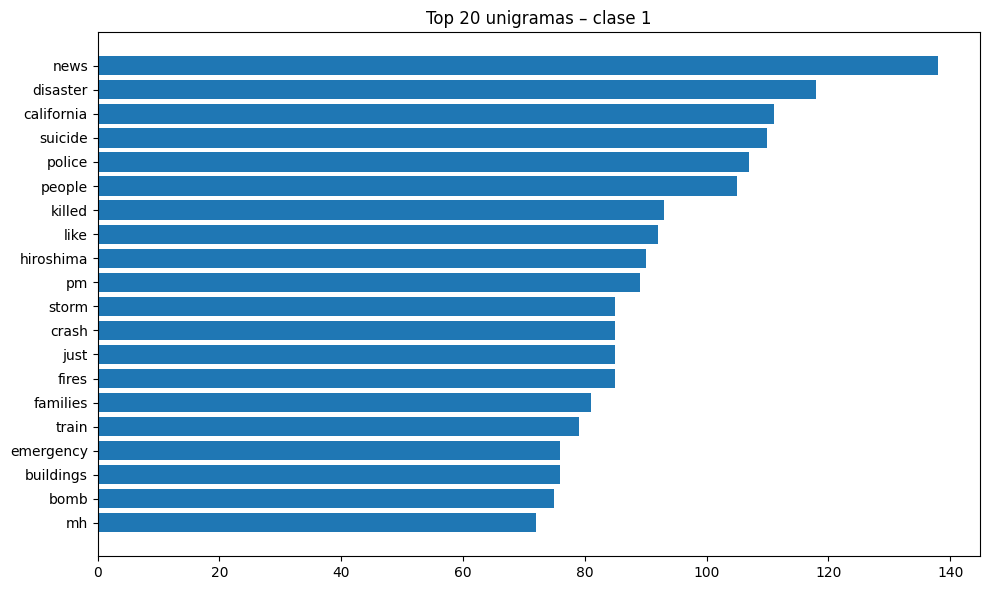

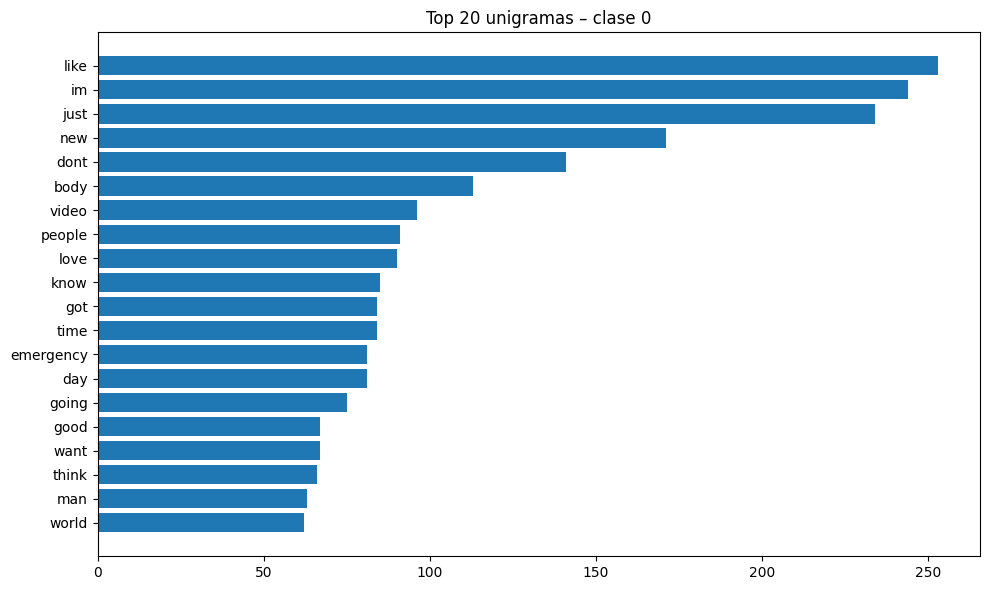

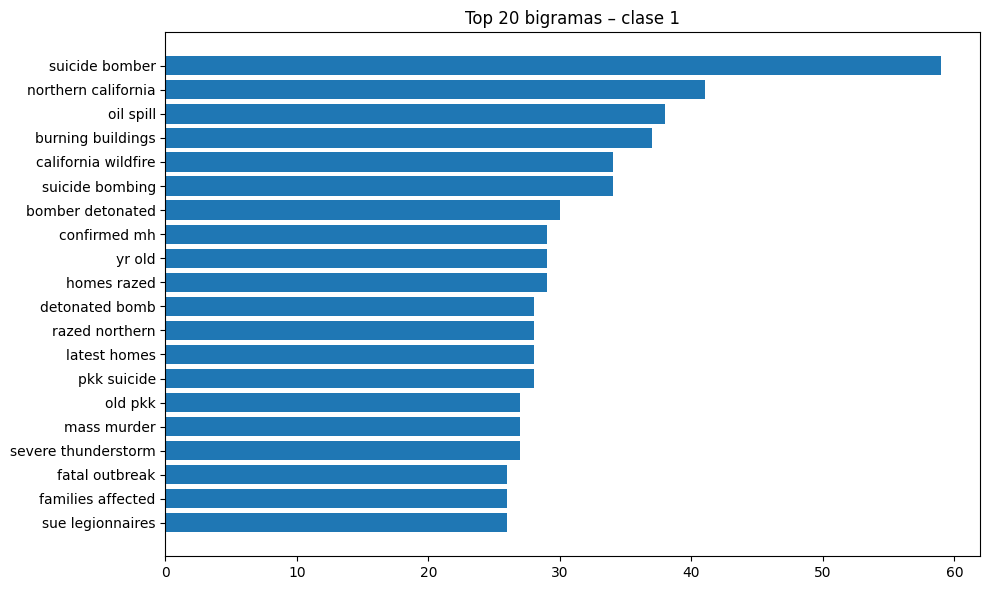

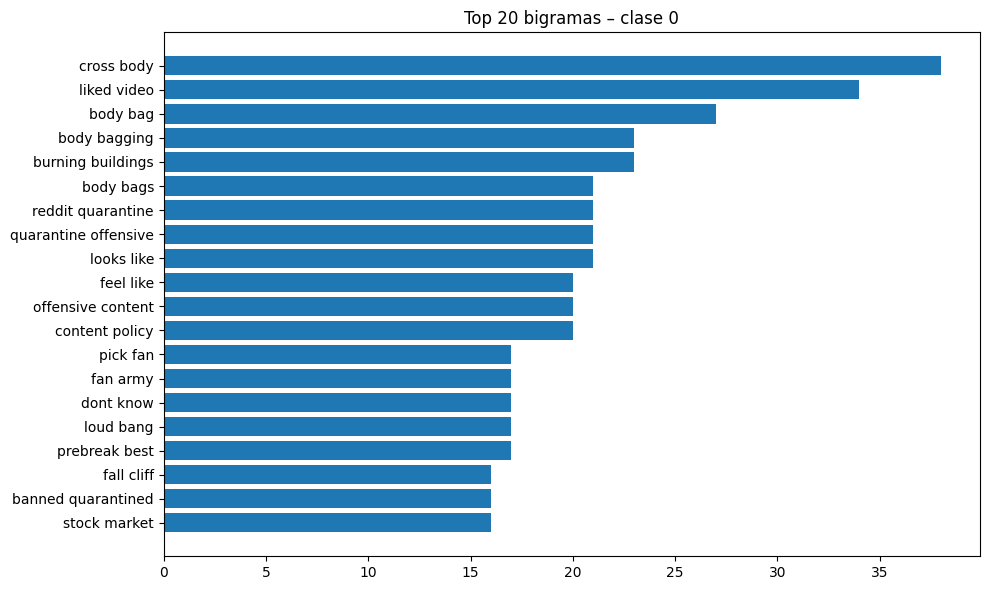

In [15]:
# Barras horizontales por clase
def plot_top_bar(df_terms, cls, title_suffix, topk=20):
    data = df_terms[df_terms["class"]==cls].head(topk).iloc[::-1]
    if data.empty:
        print(f"Clase {cls}: sin términos para graficar.")
        return
    plt.figure(figsize=(10, 6))
    plt.barh(data["term"], data["freq"])  # no especificar colores
    plt.title(f"Top {len(data)} {title_suffix} – clase {cls}")
    plt.tight_layout()
    plt.show()

# Unigramas
plot_top_bar(uni_df, 1, "unigramas", topk=20)
plot_top_bar(uni_df, 0, "unigramas", topk=20)

# Bigramas
plot_top_bar(bi_df,  1, "bigramas",  topk=20)
plot_top_bar(bi_df,  0, "bigramas",  topk=20)


### Análisis exploratorio

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Cargar dataset limpio
df = pd.read_csv("../data/train_clean.csv")

In [17]:
# ==========================================
# Palabra más repetida en cada categoría
# ==========================================
from collections import Counter

# Separar por clase
def token_counter(df, cls):
    s = df.loc[df["target"] == cls, "clean_text"].astype(str).fillna("")
    tokens = s.str.split().explode()
    tokens = tokens[tokens.str.len() > 0]  # quitar vacíos
    return Counter(tokens)

# Contar frecuencia
disaster_counts = token_counter(df, 1)
nondisaster_counts = token_counter(df, 0)

print("Palabra más frecuente en desastres:", disaster_counts.most_common(1))
print("Palabra más frecuente en NO desastres:", nondisaster_counts.most_common(1))


Palabra más frecuente en desastres: [('news', 138)]
Palabra más frecuente en NO desastres: [('like', 253)]


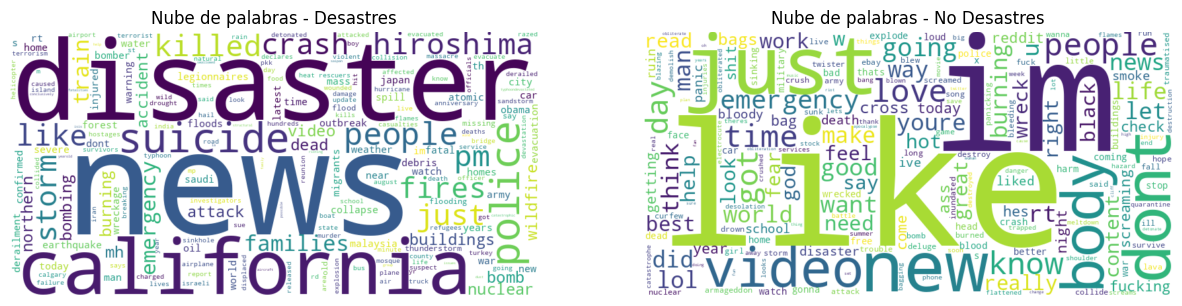

In [ ]:
# ==========================================
# Nubes de palabras por categoría
# ==========================================
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Generar wordcloud de desastres
wc_disaster = WordCloud(
    width=800, height=400, background_color="white",
    collocations=False,   
    repeat=False,         
    normalize_plurals=False 
).generate_from_frequencies(dict(disaster_counts))

axes[0].imshow(wc_disaster, interpolation="bilinear")
axes[0].set_title("Nube de palabras - Desastres")
axes[0].axis("off")

# Generar wordcloud de No desastres
wc_nondisaster = WordCloud(
    width=800, height=400, background_color="white",
    collocations=False,
    repeat=False,
    normalize_plurals=False
).generate_from_frequencies(dict(nondisaster_counts))

axes[1].imshow(wc_nondisaster, interpolation="bilinear")
axes[1].set_title("Nube de palabras - No Desastres")
axes[1].axis("off")

plt.show()

In [31]:
# ======================
# construir bi_counts_* 
# ======================
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def build_ngram_counts(df, cls, ngram=(2,2), min_df=3, max_features=None):
    s = df.loc[df["target"] == cls, "clean_text"].astype(str).fillna("")
    vec = CountVectorizer(
        ngram_range=ngram,
        min_df=min_df,
        max_features=max_features,
        token_pattern=r"(?u)\b\w+\b",
        lowercase=False,
        stop_words=None
    )
    X = vec.fit_transform(s)
    vocab = vec.get_feature_names_out()
    counts = np.asarray(X.sum(axis=0)).ravel()
    return Counter(dict(zip(vocab, counts)))

# Bigramas por clase
bi_counts_disaster = build_ngram_counts(df, cls=1, ngram=(2,2), min_df=3)
bi_counts_nondisaster = build_ngram_counts(df, cls=0, ngram=(2,2), min_df=3)

# Sanity check
print("n_bigrams(disaster):", len(bi_counts_disaster))
print("n_bigrams(non_disaster):", len(bi_counts_nondisaster))


n_bigrams(disaster): 1150
n_bigrams(non_disaster): 830


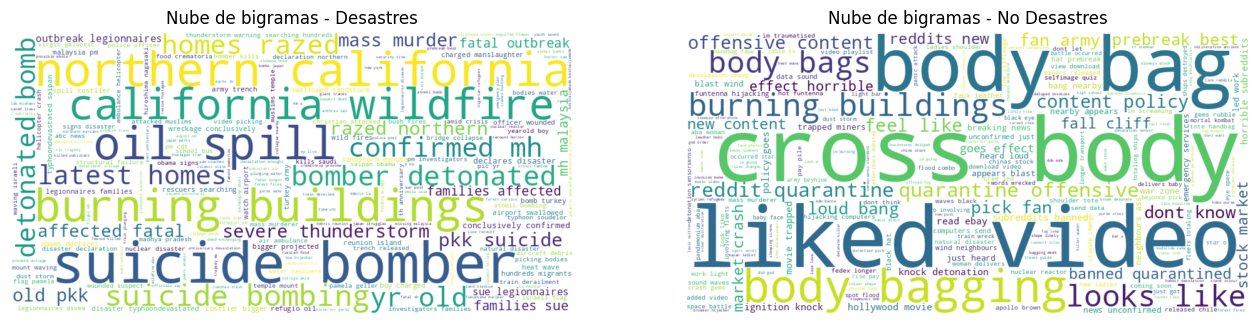

In [32]:
# ==========================================
# Nubes de bigramas por categoría
# ==========================================
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

wc_bi_dis = WordCloud(
    width=900, height=450, background_color="white",
    collocations=False, repeat=False, normalize_plurals=False
).generate_from_frequencies(dict(bi_counts_disaster))
axes[0].imshow(wc_bi_dis, interpolation="bilinear")
axes[0].set_title("Nube de bigramas - Desastres")
axes[0].axis("off")

wc_bi_non = WordCloud(
    width=900, height=450, background_color="white",
    collocations=False, repeat=False, normalize_plurals=False
).generate_from_frequencies(dict(bi_counts_nondisaster))
axes[1].imshow(wc_bi_non, interpolation="bilinear")
axes[1].set_title("Nube de bigramas - No Desastres")
axes[1].axis("off")

plt.show()


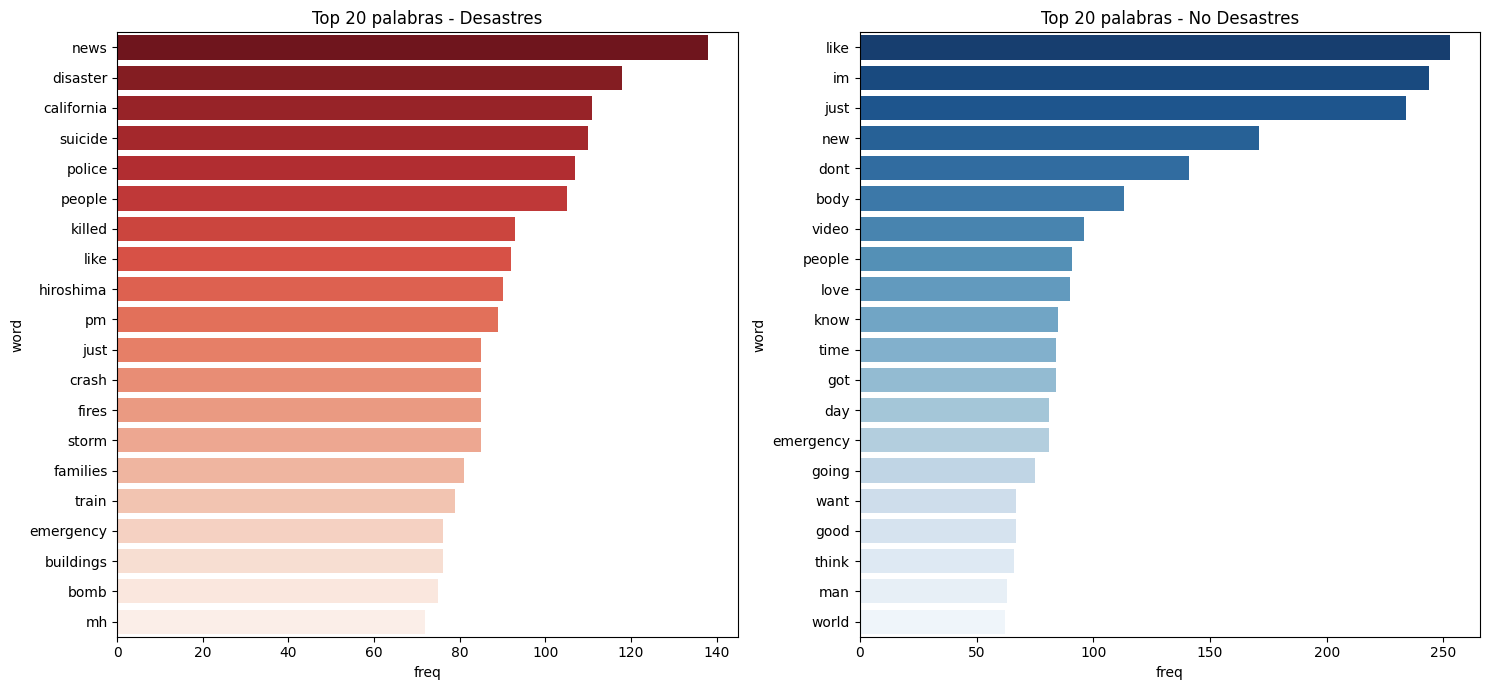

In [27]:
# ==========================================
# Histogramas de palabras más frecuentes
# ==========================================
import seaborn as sns

# Top 20 palabras en cada clase
top_disaster = pd.DataFrame(disaster_counts.most_common(20), columns=["word","freq"])
top_nondisaster = pd.DataFrame(nondisaster_counts.most_common(20), columns=["word","freq"])

fig, axes = plt.subplots(1, 2, figsize=(15,7))

sns.barplot(
    x="freq", y="word", hue="word",
    data=top_disaster, ax=axes[0],
    palette="Reds_r", legend=False
)
axes[0].set_title("Top 20 palabras - Desastres")

sns.barplot(
    x="freq", y="word", hue="word",
    data=top_nondisaster, ax=axes[1],
    palette="Blues_r", legend=False
)
axes[1].set_title("Top 20 palabras - No Desastres")

plt.tight_layout()
plt.show()


In [33]:
# ==========================================
# Palabras presentes en ambas categorías
# ==========================================
common_words = set(disaster_counts.keys()) & set(nondisaster_counts.keys())

# top 20 palabras comunes más frecuentes
common_counts = []
for word in common_words:
    total_freq = disaster_counts[word] + nondisaster_counts[word]
    common_counts.append((word, disaster_counts[word], nondisaster_counts[word], total_freq))

df_common = pd.DataFrame(common_counts, columns=["word","freq_disaster","freq_nondisaster","total"])
df_common = df_common.sort_values("total", ascending=False).head(20)

print("Palabras comunes en ambas categorías (top 20):")
print(df_common)


Palabras comunes en ambas categorías (top 20):
            word  freq_disaster  freq_nondisaster  total
859         like             92               253    345
2435        just             85               234    319
1451          im             56               244    300
3322         new             56               171    227
3430        news            138                59    197
1740      people            105                91    196
1278        dont             50               141    191
1180       video             69                96    165
170    emergency             76                81    157
1027    disaster            118                36    154
2033      police            107                34    141
1620        time             42                84    126
1989        body             12               113    125
2338     burning             64                56    120
3660       crash             85                34    119
3537       storm             85          

En el análisis de las palabras más repetidas dentro de cada categoría se observa una clara diferencia entre el vocabulario de los tweets de desastres y los de no desastres. En los primeros, la palabra más frecuente es “news”, con un total de 138 apariciones, lo cual refleja la manera en que los usuarios suelen referirse a reportes o actualizaciones sobre emergencias reales. Por el otro lado, en los tweets de no desastres la palabra que domina es “like”, con 253 apariciones, lo cual refleja un uso más cotidiano, emocional y propio del lenguaje coloquial en redes, sin relación directa con situaciones críticas.

Las nubes de palabras permiten visualizar de manera más intuitiva estas diferencias. En la categoría de desastres destacan términos como news, disaster, california, suicide, police y emergency, todos ellos asociados a hechos objetivos y graves que remiten a catástrofes naturales, accidentes o atentados. Por el otro lado, en la categoría de no desastres aparecen con mayor fuerza expresiones como like, im, just, dont, people y time, que corresponden a conversaciones personales, narraciones del día a día o comentarios emocionales.

Al observar los histogramas de las palabras más frecuentes en cada grupo, se confirma nuevamente esta diferencia de patrones. En los tweets de desastres sobresalen términos directamente vinculados a eventos críticos, como news, disaster, suicide, police, crash, storm y emergency, mientras que en los tweets de no desastres predominan expresiones de carácter subjetivo y narrativo, tales como like, im, just, video, people y time. La comparación cuantitativa de frecuencias refuerza la idea de que el vocabulario utilizado es un fuerte indicador para la clasificación automática de los mensajes.

Finalmente, el análisis de palabras comunes entre ambas categorías muestra que existe un conjunto compartido, aunque con distribuciones muy diferentes. Palabras como like, just, im, new, news, people, dont, video, emergency, disaster y police aparecen tanto en desastres como en no desastres, pero el peso relativo es lo que marca la diferencia. Por ejemplo, news, disaster, police y suicide son mucho más frecuentes en los tweets de desastres, mientras que like, im y just predominan claramente en los de no desastres. Asimismo, palabras más neutrales como people, new o time aparecen en ambos, aunque sin ser particularmente discriminantes. Este hallazgo sugiere que, aunque existe un vocabulario compartido, la frecuencia relativa de los términos es fundamental para diferenciarlos, lo cual justifica el uso de técnicas estadísticas como TF-IDF y el análisis de n-gramas para mejorar el rendimiento del modelo de clasificación.

### Modelo de clasificación

In [21]:
# Conteo original
total_antes = df.shape[0]
na_antes = df["clean_text"].isna().sum()

print("Antes de limpiar:")
print(f"  Total de filas: {total_antes}")
print(f"  Filas con NaN en clean_text: {na_antes}")
print(f"  % de NaN: {na_antes/total_antes:.2%}")

# Eliminar NaN en clean_text
df = df.dropna(subset=["clean_text"])

# Conteo después
total_despues = df.shape[0]
na_despues = df["clean_text"].isna().sum()

print("\nDespués de limpiar:")
print(f"  Total de filas: {total_despues}")
print(f"  Filas con NaN en clean_text: {na_despues}")
print(f"  Filas eliminadas: {total_antes - total_despues}")
print(f"  % de reducción: {(total_antes - total_despues)/total_antes:.2%}")

Antes de limpiar:
  Total de filas: 7613
  Filas con NaN en clean_text: 5
  % de NaN: 0.07%

Después de limpiar:
  Total de filas: 7608
  Filas con NaN en clean_text: 0
  Filas eliminadas: 5
  % de reducción: 0.07%


In [22]:
# Definición de train y test

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))

X = vectorizer.fit_transform(df["clean_text"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       868
           1       0.85      0.70      0.77       654

    accuracy                           0.82      1522
   macro avg       0.82      0.80      0.81      1522
weighted avg       0.82      0.82      0.81      1522



In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)

print('Matriz de confusión:\n',cm)
print('Accuracy: ',accuracy)

Matriz de confusión:
 [[787  81]
 [197 457]]
Accuracy:  0.8173455978975033


In [25]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text: str) -> str:
    # 1. Pasar a minúsculas
    text = text.lower()
    
    # 2. Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # 3. Eliminar menciones (@usuario) y hashtags
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    
    # 4. Eliminar números
    text = re.sub(r"\d+", "", text)
    
    # 5. Eliminar signos de puntuación
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # 6. Eliminar stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # 7. Unir de nuevo
    text = " ".join(tokens)
    
    return text


ModuleNotFoundError: No module named 'nltk'

In [ ]:
def predict_sentiment(text):
    clean = clean_text(text)
    # print(clean)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)[0]
    return "Es desastre" if pred == 1 else "No es desastre"

In [ ]:
print(predict_sentiment("News about fire in California just dropped."))
print(predict_sentiment("I love this movie, it's terrible."))
print(predict_sentiment("Hotel California is a fire song, but that aint no new news."))

Es desastre
No es desastre
No es desastre
